In [1]:
import numpy as np
import pandas as pd
import os
import gc
import copy # for copying nested dictionaries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

## Read input data into Pandas dataframes 

In [2]:
datapath = os.getcwd() + '/nbadata'
games = pd.read_csv(datapath + '/games.csv')
teams = pd.read_csv(datapath + '/teams.csv')
team_logos = pd.read_csv(datapath + '/teams_logos.csv')

In [3]:
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,3/21/2021,22000645,Final,1610612748,1610612754,2020,1610612748,106.0,0.402,0.826,...,27.0,51.0,1610612754,109.0,0.388,0.900,0.333,27.0,50.0,0
1,3/21/2021,22000016,Final,1610612745,1610612760,2020,1610612745,112.0,0.494,0.741,...,22.0,38.0,1610612760,114.0,0.462,0.680,0.333,22.0,52.0,0
2,3/21/2021,22000646,Final,1610612743,1610612740,2020,1610612743,108.0,0.500,0.800,...,30.0,37.0,1610612740,113.0,0.482,0.767,0.286,26.0,45.0,0
3,3/21/2021,22000167,Final,1610612738,1610612753,2020,1610612738,112.0,0.455,1.000,...,27.0,45.0,1610612753,96.0,0.381,0.700,0.324,20.0,44.0,1
4,3/21/2021,22000647,Final,1610612751,1610612764,2020,1610612751,113.0,0.489,0.727,...,24.0,35.0,1610612764,106.0,0.532,0.789,0.333,24.0,43.0,1


### Read games_formated.csv if it already exists

In [4]:
games_formated = pd.read_csv(datapath + '/../generated_data/games_formated.csv')

### Extract pre-determined important feature columns

This includes stats like a teams home and away win percentage in their previous games, their scoring efficacy (FG and 3-pt), as well as other team and individual stats

In [5]:
feat_cols = [
    'G_home', 'W_PCT_home', 'HOME_RECORD_home',
    'ROAD_RECORD_home', 'W_PCT_prev_home', 'HOME_RECORD_prev_home',
    'ROAD_RECORD_prev_home', 'G_away', 'W_PCT_away', 'HOME_RECORD_away',
    'ROAD_RECORD_away', 'W_PCT_prev_away', 'HOME_RECORD_prev_away',
    'ROAD_RECORD_prev_away', 'WIN_PRCT_home_3g', 'PTS_home_3g',
    'FG_PCT_home_3g', 'FT_PCT_home_3g', 'FG3_PCT_home_3g', 'AST_home_3g',
    'REB_home_3g', 'WIN_PRCT_away_3g', 'PTS_away_3g', 'FG_PCT_away_3g',
    'FT_PCT_away_3g', 'FG3_PCT_away_3g', 'AST_away_3g', 'REB_away_3g',
    'WIN_PRCT_home_10g', 'PTS_home_10g', 'FG_PCT_home_10g',
    'FT_PCT_home_10g', 'FG3_PCT_home_10g', 'AST_home_10g', 'REB_home_10g',
    'WIN_PRCT_away_10g', 'PTS_away_10g', 'FG_PCT_away_10g',
    'FT_PCT_away_10g', 'FG3_PCT_away_10g', 'AST_away_10g', 'REB_away_10g'
]
target = 'HOME_TEAM_WINS'

### Plot correlation matrix of feature columns

In [6]:
corr = games_formated[feat_cols + [target]].corr()

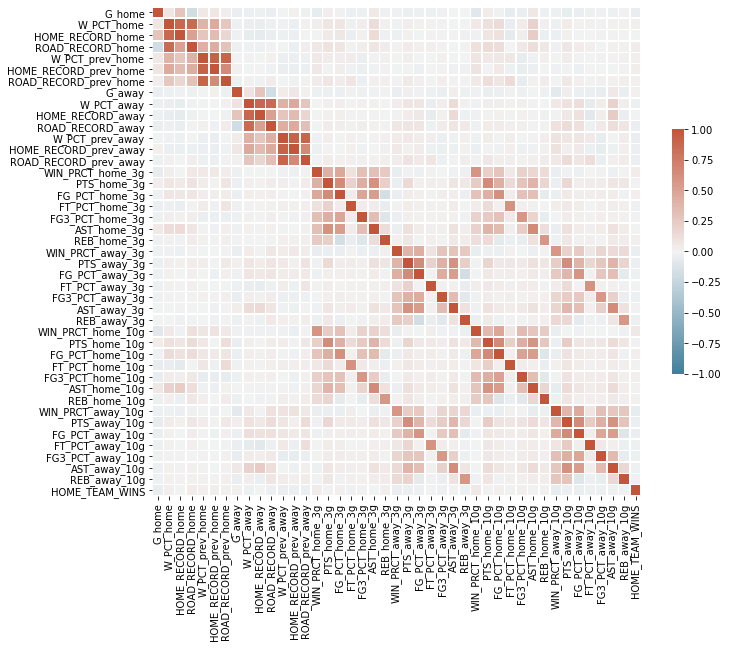

In [7]:
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=1, center=0, vmin=-1, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### Find the 15 most important features that determine HOME_TEAM_WIN

In [8]:
feat_cols = corr.nlargest(15, target)[target].index
feat_cols = [c for c in feat_cols if c != target]
print(feat_cols)

games_formated['GAME_DATE_EST'] = pd.to_datetime(games_formated['GAME_DATE_EST'])

['WIN_PRCT_home_10g', 'ROAD_RECORD_home', 'WIN_PRCT_home_3g', 'HOME_RECORD_prev_home', 'FG_PCT_home_10g', 'W_PCT_prev_home', 'W_PCT_home', 'FG_PCT_home_3g', 'FG3_PCT_home_10g', 'REB_home_3g', 'G_away', 'ROAD_RECORD_prev_home', 'REB_home_10g', 'PTS_home_10g']


### Extract training set (games before 2020 bubble) and test set (2020 bubble games)

In [9]:
training_games = games_formated[games_formated['GAME_DATE_EST'] < '7/22/2020'].sort_values(by='GAME_DATE_EST')
# drop games before 2007 to avoid NaN's in some feature columns
training_games = training_games[training_games['SEASON'] >= 2007].reset_index(drop=True)

In [10]:
games_2020 = games_formated[(games_formated['GAME_DATE_EST'] >= '7/22/2020')].sort_values(by='GAME_DATE_EST')
games_2020 = games_2020[games_2020['SEASON'] == 2019].reset_index()

In [11]:
training_games['HOME_TEAM_WINS'].value_counts(normalize=True)

1    0.61109
0    0.38891
Name: HOME_TEAM_WINS, dtype: float64

In [12]:
games_2020['HOME_TEAM_WINS'].value_counts(normalize=True)

1    0.515
0    0.485
Name: HOME_TEAM_WINS, dtype: float64

### Create training and test X and y sets

In [13]:
X_train, y_train = training_games[feat_cols], training_games[target]

X_test, y_test = games_2020[feat_cols], games_2020[target]

### Train and Evaluate 3 different classifiers to predict 2020 NBA Bubble games

#### 1. Random Forest Classifier

In [14]:
rfc = RandomForestClassifier(random_state=42, n_jobs=2, n_estimators=100, max_depth=19, bootstrap=True)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=19, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [15]:
print('Train accuracy:', rfc.score(X_train, y_train))
print('Test accuracy:', rfc.score(X_test, y_test))

Train accuracy: 0.9984962406015038
Test accuracy: 0.545


In [16]:
predictions = rfc.predict(X_test)
games_2020['RF_PREDICTION'] = rfc.predict(X_test)

games_2020['RF_PREDICTION'].value_counts(normalize=True)

1    0.79
0    0.21
Name: RF_PREDICTION, dtype: float64

#### 2. Logistic Regression Classifier

In [17]:
lr = LogisticRegression(random_state=42, C=0.01, max_iter=200, class_weight = 'balanced')
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
print('Train accuracy:', lr.score(X_train, y_train))
print('Test accuracy:', lr.score(X_test, y_test))

Train accuracy: 0.5343984962406015
Test accuracy: 0.5


In [19]:
lr_predictions = lr.predict(X_test)
games_2020['LR_PREDICTION'] = lr.predict(X_test)

games_2020['LR_PREDICTION'].value_counts(normalize=True)

1    0.615
0    0.385
Name: LR_PREDICTION, dtype: float64

#### 3. Decision Tree Classifier

In [20]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=25)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=25, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [21]:
print('Train accuracy:', dt.score(X_train, y_train))
print('Test accuracy:', dt.score(X_test, y_test))

Train accuracy: 0.9552631578947368
Test accuracy: 0.54


In [22]:
dtree_predictions = dt.predict(X_test)
games_2020['DT_PREDICTION'] = dt.predict(X_test)

games_2020['DT_PREDICTION'].value_counts(normalize=True)

1    0.655
0    0.345
Name: DT_PREDICTION, dtype: float64

### Format predictions and write output to csv for visualization

#### Adding full team names and logos to output

In [26]:
team_names = teams[['TEAM_ID', 'CITY', 'NICKNAME', 'TEAM_LOGO_URL']]
home_names = team_names.copy() # copy the names data
home_names['HOME_TEAM_ID'] = home_names['TEAM_ID'] # change the column names before merging
home_names['HOME_NAME'] = home_names['CITY'] + ' ' + home_names['NICKNAME']
home_names['HOME_LOGO'] = home_names['TEAM_LOGO_URL']
# merge names according to df on "ID"
result_1 = pd.merge(games['HOME_TEAM_ID'], home_names, how='left', on="HOME_TEAM_ID")
games['HOME_TEAM_NAME'] = result_1['HOME_NAME']
games['HOME_TEAM_LOGO'] = result_1['HOME_LOGO']

visitor_names = team_names.copy() # copy the names data
visitor_names['VISITOR_TEAM_ID'] = visitor_names['TEAM_ID'] # change the column names before merging
visitor_names['AWAY_NAME'] = visitor_names['CITY'] + ' ' + visitor_names['NICKNAME']
visitor_names['VISITOR_LOGO'] = visitor_names['TEAM_LOGO_URL']
# merge names according to df on "ID"
result_2 = pd.merge(games['VISITOR_TEAM_ID'], visitor_names, how = "left", on="VISITOR_TEAM_ID")
games['VISITOR_TEAM_NAME'] = result_2['AWAY_NAME']
games['VISITOR_TEAM_LOGO'] = result_2['VISITOR_LOGO']

#### Format final output

In [27]:
temp = games_2020[['GAME_ID', 'GAME_DATE_EST', 'HOME_TEAM_WINS', 'RF_PREDICTION', 'LR_PREDICTION', 'DT_PREDICTION']]
g2020 = temp.set_index('GAME_ID').join(games.set_index('GAME_ID'), lsuffix='_1', rsuffix='_r')

final = g2020[['GAME_DATE_EST_1', 'HOME_TEAM_NAME', 'VISITOR_TEAM_NAME', 'PTS_home', 'PTS_away', 'HOME_TEAM_WINS_1', 'RF_PREDICTION', 'LR_PREDICTION', 'DT_PREDICTION', 'HOME_TEAM_LOGO', 'VISITOR_TEAM_LOGO']]
final.rename(columns={"GAME_DATE_EST_1": "GAME_DATE_EST", "HOME_TEAM_WINS_1": "ACTUAL_RESULT"})
final = final.reset_index()
final.head()

,GAME_ID,GAME_DATE_EST_1,HOME_TEAM_NAME,VISITOR_TEAM_NAME,PTS_home,PTS_away,HOME_TEAM_WINS_1,RF_PREDICTION,LR_PREDICTION,DT_PREDICTION,HOME_TEAM_LOGO,VISITOR_TEAM_LOGO
0,11900101,2020-07-22,Los Angeles Clippers,Orlando Magic,99.0,90.0,1,0,0,0,https://content.sportslogos.net/logos/6/236/fu...,https://content.sportslogos.net/logos/6/217/fu...
1,11900102,2020-07-22,Denver Nuggets,Washington Wizards,89.0,82.0,1,1,1,1,https://content.sportslogos.net/logos/6/229/fu...,https://content.sportslogos.net/logos/6/219/fu...
2,11900103,2020-07-22,Brooklyn Nets,New Orleans Pelicans,68.0,99.0,0,0,1,1,https://content.sportslogos.net/logos/6/3786/f...,https://content.sportslogos.net/logos/6/4962/f...
3,11900104,2020-07-22,Miami Heat,Sacramento Kings,104.0,98.0,1,1,1,0,https://content.sportslogos.net/logos/6/214/fu...,https://content.sportslogos.net/logos/6/240/fu...
4,11900105,2020-07-23,Milwaukee Bucks,San Antonio Spurs,113.0,92.0,1,1,1,1,https://content.sportslogos.net/logos/6/225/fu...,https://content.sportslogos.net/logos/6/233/fu...


In [28]:
final.to_csv('generated_data/model_predictions.csv', index=False)